In [2]:
!pip install git+https://github.com/huggingface/transformers.git # Installs the transformers library from the Hugging Face GitHub repository.
!pip install pyttsx3 #Installs the pyttsx3 library, which is a text-to-speech conversion library in Python.
!pip install gTTS # Installs the gTTS (Google Text-to-Speech) library, which is used for text-to-speech conversion using Google's Text-to-Speech API.
!pip install pydub #Installs the pydub library, which provides a high-level interface for manipulating audio with Python.
!pip install playsound #Installs the playsound library, which is used to play audio files in a cross-platform way.
!pip install pyobject

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-bv37mydi
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-bv37mydi
  Resolved https://github.com/huggingface/transformers.git to commit 15c74a28294fe9082b81b24efe58df16fed79a9e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import locale
# Get the preferred encoding
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [4]:
import requests #Allows you to send HTTP requests easily in Python.
import pyttsx3
from gtts import gTTS
from IPython.display import Audio #Allows displaying an audio widget in Jupyter/Colab notebooks.
from pydub import AudioSegment #Provides a high-level interface for manipulating audio with Python
from IPython.display import display, Javascript, HTML, Image #These are components of IPython.display used for displaying HTML, executing JavaScript, and displaying images in notebooks.
from google.colab.output import eval_js #Executes JavaScript code in a Google Colab environment.
from base64 import b64decode, b64encode #Provides functions for encoding and decoding data using Base64 encoding.
import cv2 #OpenCV (Open Source Computer Vision Library) is used for computer vision tasks.
import numpy as np
import PIL # PIL (or its fork Pillow) is used for opening, manipulating, and saving many different image file formats in Python.
import io
import html
import time
import os

In [5]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [6]:
def take_photo(folder='captured_photos', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Create buttons for capturing and stopping
            const captureBtn = document.createElement('button');
            captureBtn.textContent = 'Capture';
            const stopBtn = document.createElement('button');
            stopBtn.textContent = 'Stop';
            div.appendChild(captureBtn);
            div.appendChild(stopBtn);

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;

            let intervalId;

            // Capture images every 3 seconds
            captureBtn.onclick = () => {
                intervalId = setInterval(() => {
                    canvas.getContext('2d').drawImage(video, 0, 0);
                    const data = canvas.toDataURL('image/jpeg', quality);
                    google.colab.kernel.invokeFunction('notebook.take_photo', [data], {});
                }, 3000);
            };

            // Stop capturing when the "Stop" button is clicked
            stopBtn.onclick = () => {
                clearInterval(intervalId);
                stream.getVideoTracks()[0].stop();
                div.remove();
            };
        }
        ''')

    display(js)
    eval_js('takePhoto({})'.format(quality))

In [7]:
folder = "captured_photos"
counter = 1  # Initialize counter

def save_photo(data, folder='captured_photos'):
    global counter  # Use global counter variable
    binary = b64decode(data.split(',')[1])
    if not os.path.exists(folder):
        os.makedirs(folder)
    filename = os.path.join(folder, 'photo_' + str(counter) + '.jpg')  # Unique filename with counter
    with open(filename, 'wb') as f:
        f.write(binary)
    print('Saved to {}'.format(filename))
    counter += 1  # Increment counter for the next photo

from google.colab import output
output.register_callback('notebook.take_photo', save_photo)

take_photo()

<IPython.core.display.Javascript object>

Saved to captured_photos/photo_1.jpg
Saved to captured_photos/photo_2.jpg
Saved to captured_photos/photo_3.jpg
Saved to captured_photos/photo_4.jpg


Available photos:
1. photo_4.jpg
2. photo_2.jpg
3. photo_3.jpg
4. photo_1.jpg
Enter the number corresponding to the photo you want to display: 2


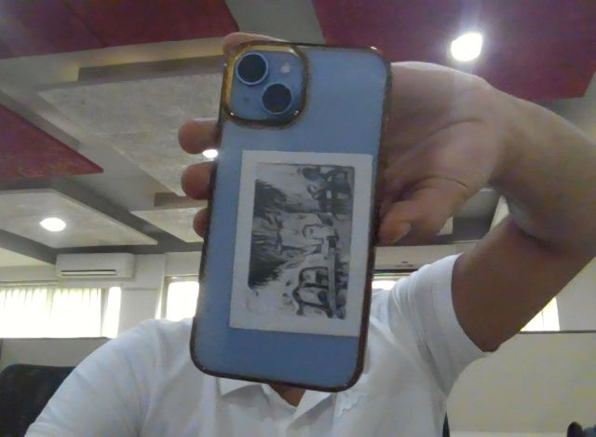

In [18]:
from PIL import Image
import os

folder_path = "captured_photos"
image_files = os.listdir(folder_path)

print("Available photos:")
for i, file_name in enumerate(image_files, start=1):
    print(f"{i}. {file_name}")

selection = input("Enter the number corresponding to the photo you want to display: ")
if selection.isdigit() and 1 <= int(selection) <= len(image_files):
    # Get the selected file name
    selected_file = image_files[int(selection) - 1]

    # Construct the full path to the selected image file
    file_path = os.path.join(folder_path, selected_file)

    image = Image.open(file_path).convert('RGB')
    image = image.resize((596, 437))

    # Display the image
    display(image)
else:
    print("Invalid selection.")

In [11]:
from transformers import AutoProcessor, BlipForConditionalGeneration
import torch

# Load a pre-trained BLIP model for conditional text generation
# Specify the model name ("arian2502/blip-icb-finetuned") and set the torch data type to float16
processor = AutoProcessor.from_pretrained("arian2502/blip-icb-finetuned")
model = BlipForConditionalGeneration.from_pretrained("arian2502/blip-icb-finetuned")

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

In [19]:
#caption generation
inputs = processor(image, return_tensors="pt").to(device, torch.float32)  # Specify float32 explicitly

generated_ids = model.generate(**inputs, max_length=50, min_length=20)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

with open("my_saved_text.txt", "a") as output_file:
    # Write the generated text to the file
    text_with_newline = generated_text + "\n"

    output_file.write(text_with_newline)

    speech = gTTS(text=generated_text, lang='en')  # Change 'en' for other languages

# Save the audio to a file
speech.save("generated_text.mp3")

#Play the generated audio
from playsound import playsound
Audio("generated_text.mp3")


a person holding a blue phone with a picture of a man in a suit and tie.


In [20]:
prompt = "this is an image of"

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=60, min_length=30)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)

with open("my_saved_text.txt", "a") as output_file:
    # Write the generated text to the file
    text_with_newline=generated_text + "\n"
    output_file.write(text_with_newline)
speech = gTTS(text=generated_text, lang='en')  # Change 'en' for other languages

# Save the audio to a file
speech.save("generated_text.mp3")

#Play the generated audio
from playsound import playsound
Audio("generated_text.mp3")


this is an image of a person holding a phone.


In [21]:
prompt = "Question: What kind of image is the person trying to display? Answer:"

inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=60, min_length=30)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

print(generated_text)
with open("my_saved_text.txt", "a") as output_file:
    # Write the generated text to the file
    text_with_newline=generated_text + "\n"
    output_file.write(text_with_newline)
speech = gTTS(text=generated_text, lang='en')  # Change 'en' for other languages

# Save the audio to a file
speech.save("generated_text.mp3")

#Play the generated audio
from playsound import playsound
Audio("generated_text.mp3")


question : what kind of image is the person trying to display? answer :


In [22]:
context = [
   ("What kind of image is the person playing ?", "He is showing the back of his phone with a picture of a drawing inside it"),
   ("Where is he showing it?", "In his phone")
]
question = "What for?"
template = "Question: {} Answer: {}."

prompt = " ".join([template.format(context[i][0], context[i][1]) for i in range(len(context))]) + " Question: " + question + " Answer:"

print(prompt)

Question: What kind of image is the person playing ? Answer: He is showing the back of his phone with a picture of a drawing inside it. Question: Where is he showing it? Answer: In his phone. Question: What for? Answer:


In [23]:
inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)

generated_ids = model.generate(**inputs, max_new_tokens=52, min_length=30)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
print(generated_text)
with open("my_saved_text.txt", "a") as output_file:
    # Write the generated text to the file
    text_with_newline=generated_text + "\n"
    output_file.write(text_with_newline)
speech = gTTS(text=generated_text, lang='en')  # Change 'en' for other languages

# Save the audio to a file
speech.save("generated_text.mp3")

#Play the generated audio
from playsound import playsound
Audio("generated_text.mp3")


question : what kind of image is the person playing? answer : he is showing the back of his phone with a picture of a drawing inside it. question : where is he showing it? answer : in his phone. question : what for? answer :
